##Introduction and Environment Setup

In [ ]:
%%capture

# First ensure DASCore is installed. If not, install and restart the kernel.
try:
    import dascore as dc
except ImportError:
    !pip install dascore
    !pip install ipympl
    # resetart kernel
    import IPython
    IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel


import numpy as np
from rich import print

##Import dascore

In [ ]:
import dascore as dc

In [ ]:
dc.__version__

'0.1.6'

##Read data from file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If you're pulling data from Google Drive, you'll need to make a shortcut to the directory you're referring to.  
If your shortcut of "Example_data" is in "MyDrive", then you can use the cell below directly.  

In [ ]:
spool=dc.spool("drive/MyDrive/Example_data/Microseismicity_example_data/FORGE_DFIT_UTC_20220421_055624.398.tdms")

##Access data patch

In [ ]:
contents = spool.get_contents()
display(contents)

,data_type,data_category,data_units,instrument_id,acquisition_id,tag,station,network,dims,path,...,time_dtype,time_min,time_max,time_step,time_units,distance_dtype,distance_min,distance_max,distance_step,distance_units
0,strain_rate,,None,01CE1469,,,,,"time,distance",drive/MyDrive/Example_data/Microseismicity_exa...,...,datetime64,2022-04-21 05:56:24.398177,2022-04-21 05:56:39.397927,0 days 00:00:00.000250,s,float64,2483.955264,4965.889576,1.020952,m


The data is from the Utah FORGE 16A(78)‐32 Stimulation in 2022 April ([Utah FORGE Data Distribution](https://constantine.seis.utah.edu/)).  
The data file contains 15s long DAS record.  
Within this time period, according to the event catalog from Silixa ([Silixa LLC report](https://gdr.openei.org/submissions/1423)), event 102 was at UTC 2022-04-21T05:56:37.929000.  

In [ ]:
#get patch from spool
patch=spool[0]

Vertical well 78A and 78B are sharing one cable, only 2 part of the cable contains usable data. According to the sensor details, 78A is between channel 91 and 1061, 78B is between channel 1215 and 2384  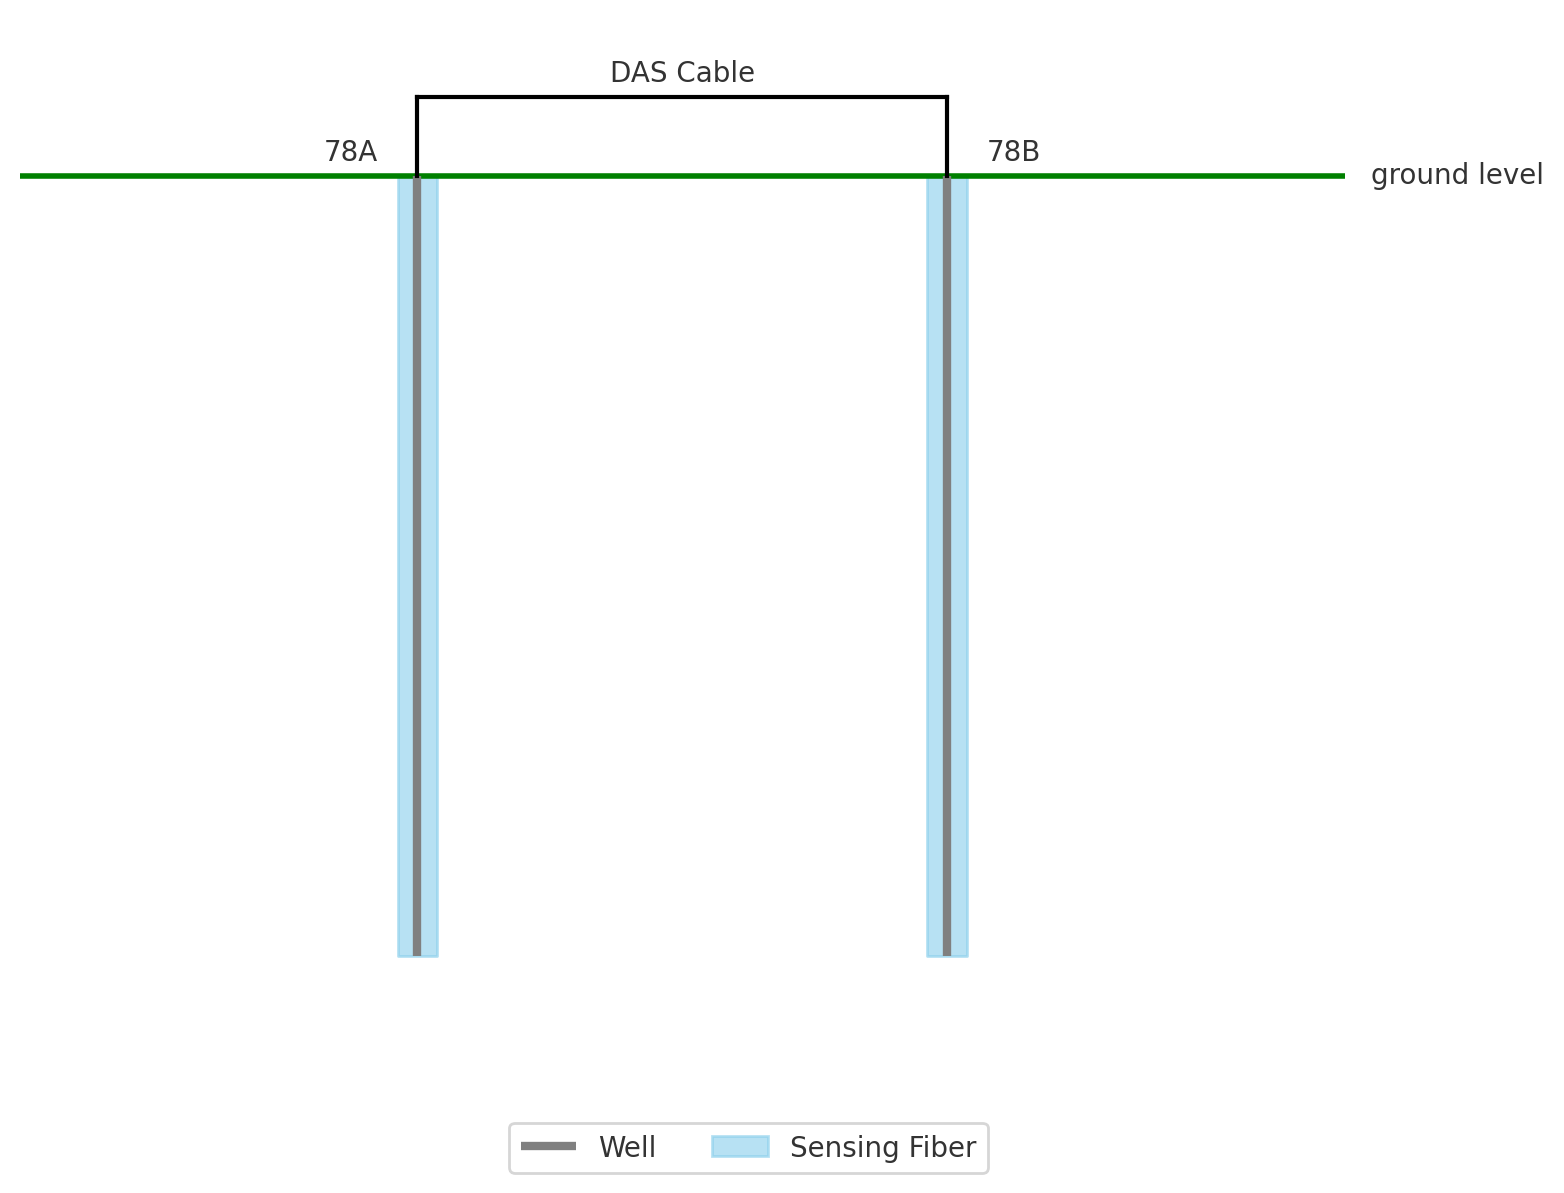

Sensor Details:  
$$
\begin{array}{|c|c|c|}
\hline
\textbf{Sensor} & \textbf{Position} & \textbf{Channel} \\
\hline
{\text{78A}} & \text{bottom} & 91 \\
                            & \text{top}    & 1061 \\
\hline
{\text{78B}} & \text{top}    & 1215 \\
                            & \text{bottom} & 2384 \\
\hline
\end{array}
$$

##Check coordinates

In [ ]:
time = patch.get_coord("time")#time coord
distance = patch.get_coord("distance")#distance coord
t1 = time.min()
t2 = time.max()
print(time)
print(distance)

CoordRange( min: 2022-04-21T05:56:24.398177 max: 2022-04-21T05:56:39.397927 step: 0.00025s shape: (60000,) dtype: datetime64[ns] units: s )
CoordRange( min: 2.48e+03 max: 4.97e+03 step: 1.02 shape: (2432,) dtype: float64 units: m )


We need to update the coordinate to use channel number to discribe distance, since the positions of 78A and 78B are discribed by channel number in the sensor details.

In [ ]:
new_coord = dc.core.get_coord(start=1, stop=2433, step=1)#channel number, from 1 to 2433

patch_channel = patch.update_coords(distance = new_coord)

patch_channel = patch_channel.rename_coords(distance="channel")

print(patch_channel.coords)

➤ Coordinates (time: 60000, channel: 2432)
    *time: CoordRange( min: 2022-04-21T05:56:24.398177 max: 2022-04-21T05:56:39.397927 step: 0.00025s shape: (60000,) dtype: datetime64[ns] units: s )
    *channel: CoordRange( min: 1 max: 2432 step: 1 shape: (2432,) dtype: int64 )


##Select the fiber segment and time window

Waterfall plot of data

/usr/local/lib/python3.11/dist-packages/dascore/viz/waterfall.py:32: RuntimeWarning: overflow encountered in scalar subtract
  modifier = 0.5 * (np.nanmax(data) - np.nanmin(data))


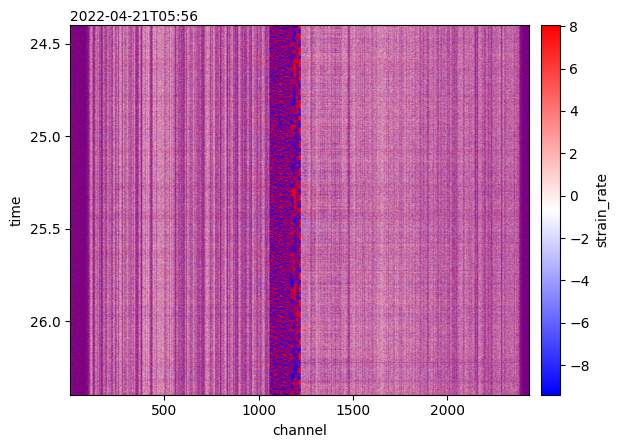

<Axes: xlabel='channel', ylabel='time'>

In [ ]:
patch_select = patch_channel.select(time=(t1+dc.to_timedelta64(0.0), t1+dc.to_timedelta64(2.0)))
patch_select.viz.waterfall(show=True, scale=0.001)

Select the fiber segment containing 78A and 78B, as well as the time window corresponding to the seismic event

In [ ]:
#channel 95~1050 for 78A and channel 1225~2383 for 78B
patch_A_raw=patch_channel.select(channel=(95,1050),time=(t1+dc.to_timedelta64(13.6),t1+dc.to_timedelta64(14.6)))
patch_B_raw=patch_channel.select(channel=(1225,2383),time=(t1+dc.to_timedelta64(13.6),t1+dc.to_timedelta64(14.6)))

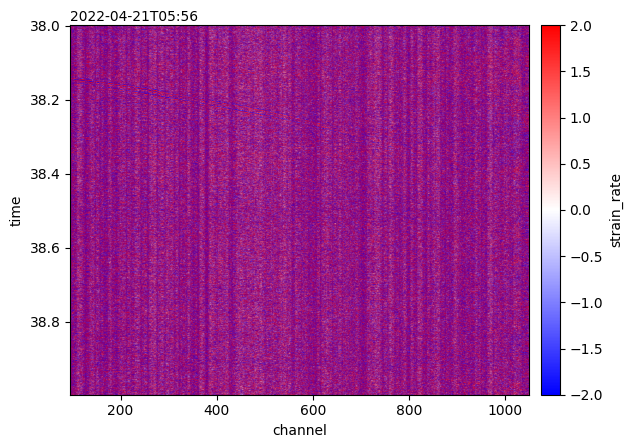

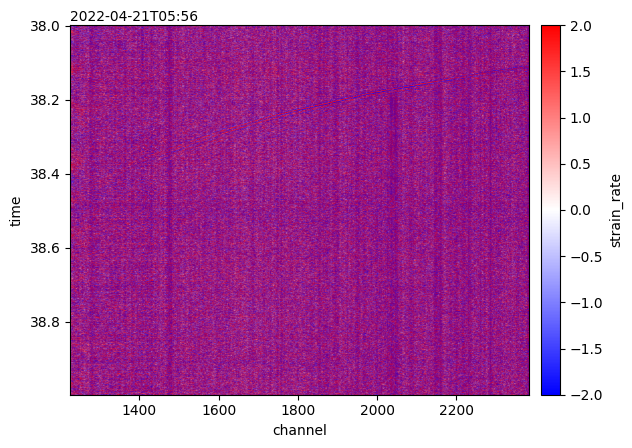

<Axes: xlabel='channel', ylabel='time'>

In [ ]:
#waterfall plot of one second long data segment in 78A and 78B, containing event 102 (at UTC 2022-04-21T05:56:38)
patch_A_raw.viz.waterfall(show=True, scale=(-2.0,2.0))
patch_B_raw.viz.waterfall(show=True, scale=(-2.0,2.0))

##Tapering and Filtering

In [ ]:
patch_filtered = (
    patch_channel.taper(time=0.075)#7.5% tapering, hann window
    .pass_filter(time=(10, 150))#10~150 Hz bandpass filter
)

In [ ]:
patch_A = patch_filtered.select(channel=(95, 1050),time=(t1+dc.to_timedelta64(13.6),t1+dc.to_timedelta64(14.6)))
patch_B = patch_filtered.select(channel=(1225, 2383),time=(t1+dc.to_timedelta64(13.6),t1+dc.to_timedelta64(14.6)))

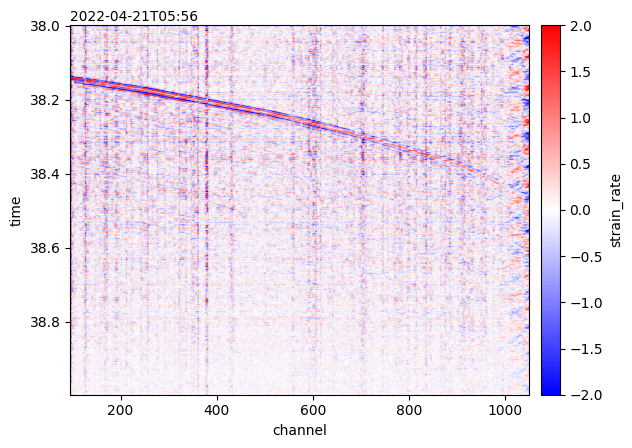

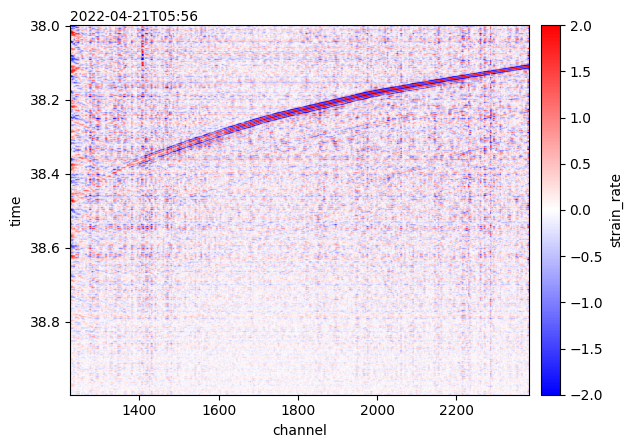

<Axes: xlabel='channel', ylabel='time'>

In [ ]:
#waterfall plot of one second long data segment in 78A and 78B, containing event 102 (at UTC 2022-04-21T05:56:38)
patch_A.viz.waterfall(show=True, scale=(-2.0,2.0))
patch_B.viz.waterfall(show=True, scale=(-2.0,2.0))